In [ ]:
import wave
import os
import glob
import soundfile as sf
from scipy.signal import spectrogram, butter, lfilter, decimate, hilbert, resample
from scipy import stats
from PIL import Image
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

    
VOLUME_AMP_MULTIPLE = 20
NPERSEG = 256
NOVERLAP = int(NPERSEG * 0.25)
WINDOW = 'hanning'
SPECTROGRAM_RAW_LOW = 1
SPECTROGRAM_RAW_HIGH = 4
SPECTROGRAM_POWER_FACTOR = 4
LOWCUT = 4500
HIGHCUT = 9500
SPECTROGRAM_HEIGHT = int(64)
morph_elem = 0
morph_size = 0
morph_operator = 0
element=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))

def fade_in(data, samples):
    samples=math.ceil(samples)
    g=np.linspace(0,1,samples)
    data[: samples]=np.multiply(data[:samples],g)
    return data;

def fade_out(data, samples):
    samples=math.ceil(samples)
    g=np.linspace(1,0,samples)
    data[(len(data)-samples) :]=np.multiply(data[(len(data)-samples) :],g)
    return data;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def getEnvelope(inputSignal,intervalLength):
    absoluteSignal = []
    print('getting envelope..')
    for sample in inputSignal:
        absoluteSignal.append (abs (sample))
    outputSignal = []
    for baseIndex in range (0, len (absoluteSignal)):
        maximum = 0
        for lookbackIndex in range (intervalLength):
            maximum = max (absoluteSignal [baseIndex - lookbackIndex], maximum)
        outputSignal.append (maximum)
    print('done getting envelope..')
    return outputSignal 


def wav_to_spectrogram(data, samplerate, norm, threshold): 
    #makes spectrogram, resizes to 100 square, flattens    
    f, t, spec = spectrogram(data,fs=float(samplerate),window=WINDOW,nperseg=NPERSEG,noverlap=NOVERLAP,mode='magnitude')    
    sel=np.where(np.logical_and(f>=3000, f<=15000))
    spec=spec[sel][:]
    spec=np.flipud(spec)
    spec=spec+0.0001
    #spec(np.nonzero(spec))=spec(np.nonzero(spec)))
    spec=np.log10(spec)*20
    spec = cv2.resize(spec, (100, 100)) 
    if(norm==1):
        norm_image = np.zeros((100,100))
        cv2.normalize(spec, norm_image, 0, 1, norm_type=cv2.NORM_MINMAX)
    #print(np.min(norm_image), np.max(norm_image))
        tmp = norm_image.reshape(1,10000)
    else:
        tmp=spec
    p = np.percentile(tmp, threshold)
    
    if(norm==1):
        th, im_th = cv2.threshold(norm_image, p, 1, cv2.THRESH_TOZERO)
    else:
        th, im_th = cv2.threshold(spec, p, 1, cv2.THRESH_TOZERO)        
        
    #im=im_th
    im = im_th.reshape(1,10000)    
    return im;    
    

#define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)    
    
    
def load_wavs(directory):
    os.chdir(directory)
    wavefiles = glob.glob('*.wav')
    imstack=pd.DataFrame()
    for idx, wavefile in enumerate(wavefiles):
        data, samplerate = sf.read(wavefile) 
        data=fade_in(data,0.005*samplerate)
        data=fade_out(data,0.005*samplerate)
        target_length=round(samplerate*0.5)
        actual_length=len(data)
        difference=target_length-actual_length
        d=round(difference/2)
    
        if(d>0):
            data=np.pad(data, (d, d), 'constant')
        if(d<0):
            d=d*-1
            data=data[d :]
            q=len(data)-d
            data=data[: q]  
    
        f, t, spec = spectrogram(data,fs=float(samplerate),window=WINDOW,nperseg=NPERSEG,noverlap=NOVERLAP,mode='magnitude')
        spec=np.flipud(spec)
        spec=spec[:45][:]
        spec = cv2.resize(spec, (100, 100))   
        p = np.percentile(spec, 98)
        th, im_th = cv2.threshold(spec, p, 1, cv2.THRESH_BINARY)
        im = im_th.reshape(1,10000)
        if idx==0:
            imstack=im
        if idx>0:
            imstack=np.append(imstack,im,axis=0)   
    return imstack, idx;

def max_rolling1(a, window,axis =1):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return np.max(rolling,axis=axis)

def load_wavs_chop(filename, envelope_threshold):
    wavefiles = glob.glob('*.wav')
    data, samplerate = sf.read(filename)
    data=data*100
#    data=butter_bandpass_filter(data, 4000, 10000, samplerate, order=5)
    data=butter_bandpass_filter(data, 3000, 15000, samplerate, order=5)
    
    plt.plot(data[:round(0.5*samplerate)])# plotting the graph
   
    data_ds=decimate(data, 4)
    samplerate_ds=int(samplerate/4)
    data_ds=data
    samplerate_ds=samplerate
    
    analytic_signal = hilbert(data_ds)
    amplitude_envelope = np.abs(analytic_signal)
    amplitude_envelope = max_rolling1(amplitude_envelope,200)
    call=np.zeros(len(amplitude_envelope), dtype=float, order='C')
    #print(len(call))
    #envelope_threshold=np.percentile(amplitude_envelope, 20)
    #envelope_threshold=0.02
    for i in range(0, len(call)):
        if(amplitude_envelope[i]>envelope_threshold):
            call[i]=1
    a=call
    plt.plot(a[:round(0.5*samplerate)])   
    plt.plot(amplitude_envelope[:round(0.5*samplerate)])
    plt.show() #Displaying the figures 
    
    return call, data, data_ds, samplerate_ds, samplerate;        
   
def show_spectrograms(imstack, idx):
    rows=math.ceil(math.sqrt(idx+1))
    cols=rows
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))  
    for idx, wavefile in enumerate(wavefiles):
        im=imstack[idx][:].reshape(100,100)
        #ax.ravel()[idx].imshow(im,cmap='binary')
        ax.ravel()[idx].imshow(im,cmap='gray')
        ax.ravel()[idx].set_title(wavefiles[idx])
        ax.ravel()[idx].set_axis_off()
    plt.show()  
    
    
def show_spectrograms_column(imstack, idx):
    rows=idx+1
    cols=1
    fig, ax = plt.subplots(nrows=rows, ncols=cols ) 

    for idx, wavefile in enumerate(wavefiles):
        im=imstack[idx][:].reshape(100,100)
        #ax.ravel()[idx].imshow(im,cmap='binary')
        ax.ravel()[idx].imshow(im)
        ax.ravel()[idx].set_title(wavefiles[idx])
        ax.ravel()[idx].set_axis_off()
    fig.tight_layout()
    plt.show()      

def set_to_target_length(data,target_length):
    q=len(data)-target_length
    #print(data.shape)
    #print(target_length, len(data), q)
    if(q==0):
        data=fade_in(data,0.005*samplerate)
        data=fade_out(data,0.005*samplerate)
    if q<0:
        data=fade_in(data,0.005*samplerate)
        data=fade_out(data,0.005*samplerate)
        data=np.append(data,np.zeros(abs(q)))
        #print('q<0, ',  len(data))
    if q>0:
        data=data[:target_length]
        data=fade_in(data,0.005*samplerate)
        data=fade_out(data,0.005*samplerate) 
        #print('q>0, ', len(data))
    return data;
     
def calls_to_new_call_list(call,samplerate, samplerate_ds):   
    cnt=-1
    previous_one=0
    callstart_sec=[]
    callstop_sec=[]
    callduration_sec=[]
    for i, c in enumerate(call):
        if i==0:
            previous_one=0
            c=0
        if i>0:
            if i % 1000000 == 0:
                print(i)
            if(previous_one==0 and c==1):
                #start
                call_state=1
                cnt+=1
                callstart_sec=np.append(callstart_sec,i/samplerate_ds)
            if(previous_one==1 and c==0):
                #end
                call_state=0;
                callstop_sec=np.append(callstop_sec,i/samplerate_ds)
                #print(cnt, len(callstop_sec), len(callstart_sec))                
                callduration_sec=np.append(callduration_sec,callstop_sec[cnt]-callstart_sec[cnt])
            previous_one=c

    target_length=int(0.25*samplerate)
    calls_nwdata=pd.DataFrame()
    cntnw=-1
    for i, dur_sec in enumerate(callduration_sec):  
        if(dur_sec>0.05):
            cntnw+=1
            #print(int(callstart_sec[i]*samplerate), int(callstop_sec[i]*samplerate))
            tmp=data[int(callstart_sec[i]*samplerate):int(callstop_sec[i]*samplerate)]
            if(dur_sec>=0.25):
                #print('dur>25')
                tmp=tmp[:round(0.25*samplerate)]
                tmp=set_to_target_length(tmp,target_length) #includes fading in and out
            if(dur_sec<0.25):
                #print('dur<.25')
                tmp=fade_in(tmp,0.005*samplerate)
                tmp=fade_out(tmp,0.005*samplerate)
                d=round((target_length-len(tmp))/2)
                #print(d)
                tmp=np.pad(tmp, (d, d), 'constant')
                tmp=set_to_target_length(tmp,target_length) #includes fading in and out
   
            tmp=tmp.reshape(1,len(tmp))
            if cntnw==0:
                calls_nwdata=tmp
            if cntnw>0:
                calls_nwdata=np.append(calls_nwdata,tmp,axis=0)            
    return calls_nwdata;

    
#here we use the functions ..  

tp_arr=['Tr','Tr1','Ph','Tw','Chi']
bigctr=4
    
wavfile='/Users/rogierlandman/from_Samsung/Samvaran_training_data/Long_filtered_' + tp_arr[bigctr] + '.wav'
impickle_file='/Users/rogierlandman/from_Samsung/Samvaran_training_data1/' + tp_arr[bigctr] + '.pkl'
wavpickle_file='/Users/rogierlandman/from_Samsung/Samvaran_training_data1/' + tp_arr[bigctr] + '_waves.pkl'
savetxt_file='/Users/rogierlandman/from_Samsung/Samvaran_training_data1/' + tp_arr[bigctr] + '_list.csv'

ampli_threshold=0.1
call, data, data_ds, samplerate_ds, samplerate=load_wavs_chop(wavfile, ampli_threshold)    
calls_nwdata = calls_to_new_call_list(call, samplerate, samplerate_ds)
nrows=np.size(calls_nwdata, axis = 0)
imstack=pd.DataFrame()
idx=-1
keeplist=[]
print(calls_nwdata.shape)
for i in range(0, nrows):
    normalize_yn=1
    percentile_threshold=92
    im_flat=wav_to_spectrogram(calls_nwdata[i], samplerate, normalize_yn, percentile_threshold)
    #evaluate whether to keep it  
    im_flat=im_flat.reshape(1,10000)
    print(np.min(im_flat), np.max(im_flat))
    im_square=im_flat.reshape(100,100)
    figure= plt.figure() 
    axis1 = figure.add_subplot(2,1,1)
    axis1.plot(calls_nwdata[i])
    axis2 = figure.add_subplot(2,1,2)
    axis2.imshow(im_square*255,cmap='gray')
    plt.show()  
    keep = str(input("Keep(y/n)? : ") or "y")
    if keep == 'y':
        idx+=1
        keeplist=np.append(keeplist,i) 
        if idx==0:
            imstack=im_flat
        if idx>0:
            imstack=np.append(imstack,im_flat,axis=0)
    plt.close(figure)
print(imstack.shape)    

imstack1=pd.DataFrame(imstack)
calls_nwdata1=pd.DataFrame(calls_nwdata)
imstack1.to_pickle(impickle_file)
calls_nwdata1.to_pickle(wavpickle_file)
np.savetxt(savetxt_file, keeplist, delimiter=',')
    
print('done')

In [40]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import cv2 as cv
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, leastsq
from scipy.interpolate import CubicSpline
import numpy as np
from scipy import signal
import scipy.stats as stats
from csaps import csaps

infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data1/Ph.pkl','rb')
imstack_ph=pickle.load(infile)
infile.close()

infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data1/Tr.pkl','rb')
imstack_tr=pickle.load(infile)
infile.close()

infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data1/Tr1.pkl','rb')
imstack_tr1=pickle.load(infile)
infile.close()

infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data1/Tw.pkl','rb')
imstack_tw=pickle.load(infile)
infile.close()
    
infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data1/Chi.pkl','rb')
imstack_chi=pickle.load(infile)
infile.close()
  
#imstack_ph=imstack_ph[:57]
imstack_tw=imstack_tw[:100]
#imstack_chi=imstack_chi[:57]

print(imstack_ph.shape[0])
print(imstack_tr.shape[0])
print(imstack_tr1.shape[0])
print(imstack_tw.shape[0])
print(imstack_chi.shape[0])

df=imstack_tr
df=df.append(imstack_tr1)
df=df.append(imstack_ph)
df=df.append(imstack_tw)
df=df.append(imstack_chi)

cat=[]
tmp=np.ones((imstack_tr.shape[0],), dtype=int) - 1
cat=np.append(cat,tmp) 
tmp=np.ones((imstack_tr1.shape[0],), dtype=int) - 1
cat=np.append(cat,tmp) 
tmp=np.ones((imstack_ph.shape[0],), dtype=int)
cat=np.append(cat,tmp) 
tmp=np.ones((imstack_tw.shape[0],), dtype=int) + 1
cat=np.append(cat,tmp) 
tmp=np.ones((imstack_chi.shape[0],), dtype=int) + 2
cat=np.append(cat,tmp) 

with_plot=0

ctr=0
BigF=np.zeros(23)

for index, row in df.iterrows():   
#print(index)
#row=df.iloc[80, :]#phee call
#row=df.iloc[7, :]#trill call
#row=df.iloc[7, :]
    ctr+=1
    row=row.to_numpy()
    row_nonzero=row[row != 0]    

    #feature: amplitude
    amplitude1=np.mean(row_nonzero)

    im_square=row.reshape(100,100)
    im_square=im_square*255
    im = im_square.astype(np.uint8)

    #plot
    if(with_plot==1):
        fig, axs = plt.subplots(3, 2)
        axs[0,0].imshow(im)
        plt.draw()
        plt.show()
    #         keep = str(input("Continue(y/n)? : ") or "y")
    #         if keep == 'y':
    #             #do nothing
    #             print(index)
    #         if keep == 'n':
    #             break       
    #         plt.close(fig)


    max_in_column = np.argmax(im,axis=0)#index of the maximum
    max_in_column_for_fft=max_in_column

    max_in_column=max_in_column[max_in_column != 0]#only nonzero values

    mean_in_column = np.mean(im,axis=0)#index of the maximum
    mean_in_column=mean_in_column[mean_in_column != 0]#only nonzero values    

    M=max_in_column

    #linear fit
    model = np.polyfit(range(len(M)),M, 1)

    #feature: slope of linear fit
    linslope=model[0]

    predict = np.poly1d(model)
    x_lin_reg = np.linspace(0,len(M),len(M), endpoint=False)
    #print(x_lin_reg)
    y_lin_reg = predict(x_lin_reg)

    #Feature: r2 score of linear fit
    r2_line=r2_score(M, y_lin_reg)

    #plot
    if(with_plot==1):
        axs[0,1].plot(range(len(M)),M)
        axs[0,1].set_title('max in columns')
        axs[0,1].plot(x_lin_reg, y_lin_reg, c = 'r')
        axs[0,1].set_ylim([0,100])

    #sinusoid fit
    M_detrended = signal.detrend(M)

    z=np.linspace(0,len(max_in_column_for_fft),len(max_in_column_for_fft), endpoint=False)
    tt=z/(2*np.pi)
    yy=max_in_column_for_fft
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    #print(ff.shape())
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_mean = np.mean(M_detrended)
    guess_phase = 0

    #print(abs(Fyy), guess_freq)

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*z+x[2]) + x[3] - yy
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    # recreate the fitted curve using the optimized parameters
    data_fit = est_amp*np.sin(est_freq * z + est_phase) + est_mean

    #feature: Sine fit frequency: est_freq
    est_freq_sine=est_freq

    #feature: Sine fit amplitude: est_amp
    est_amp_sine=est_amp

    #feature: Sine fit frequency r2 score for sine fit
    r2_sine=r2_score(yy, data_fit)

    #plot
    if(with_plot==1):
        axs[1,0].plot(range(len(max_in_column_for_fft)),max_in_column_for_fft)
        axs[1,0].plot(z, data_fit)
        axs[1,0].set_title('detrended')
        axs[1,0].set_ylim([-20,20])


    #quadratic fit
    model = np.polyfit(range(len(M)),M, 2)

    #feature: param 0 of quad fit
    quadratic0=model[0]

    #feature: param 1 of quad fit
    quadratic1=model[1]

    predict = np.poly1d(model)
    x_lin_reg = np.linspace(0,len(M),len(M), endpoint=False)
    y_quad_reg = predict(x_lin_reg)

    #Feature: r2 score of quadratic fit
    r2_quad=r2_score(M, y_quad_reg)



    #cubic spline fit
    x = x_lin_reg
    y = M
    #cs = CubicSpline(x, y, bc_type='clamped')
    ys = csaps(x, y, x, smooth=0.2)




    diff_ys=np.diff(ys)
    #plt.plot(x, y, 'o', xs, ys, '-')


    #feature: abs_sum_diff_ys, total amount of change in frequency
    abs_sum_diff_ys=np.abs(np.sum(diff_ys))


    if(with_plot==1):
        axs[1,1].plot(range(len(M)),M)
        axs[1,1].set_title('spline fit')
        axs[1,1].plot(x, ys, c = 'r')
        axs[1,1].set_ylim([0,100])





    #feature: call length
    call_length=M.shape[0]


    diff_M=np.diff(M)


    if(with_plot==1):
        axs[2,0].plot(range(len(diff_M)),diff_M)
        axs[2,0].set_title('diff max')
        axs[2,0].set_ylim([-10,10])


    #print(diff_M)

    zero_crossings = np.where(np.diff(np.sign(diff_ys)))[0]
    zero_crossings=len(zero_crossings)/len(ys)      
    #feature: zeros crossings (number of times the frequency has switched from increase to decrease and vice versa)
    #is a measure of the amount of 'squiggle'
    #print(zero_crossings)

    ret,thresh = cv.threshold(im,180,255,cv.THRESH_BINARY)



    #plt.imshow(thresh)
    #im2, cnts, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    #print("Number of Contours found = " + str(len(contours))) 
    #create an empty image for contours
    img_contours = np.zeros(im.shape)
    # draw the contours on the empty image
    cv.drawContours(img_contours, contours, -1, 255, 1)
    i=0
    area=[]
    for c in contours:
        area = np.append(area, cv.contourArea(c))
        i+=1
        #print(area)
    #print(np.amax(area))
    result = np.where(area == np.amax(area))
    #print(result[0])
    #print(contours[int(result[0])])

    #feature: area of biggest contour
    tmp1=int(result[0])
    F=np.array(tmp1)
    AR=area[result[0]]
    #print(AR)

    hull = cv.convexHull(contours[tmp1])
    #print('hull: ', hull[1][0])

    #feature: is contour convex?
    k = cv.isContourConvex(contours[tmp1])
    #print(k)

    #feature: Centroid of bbiggest contour
    M = cv.moments(contours[tmp1])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    #print(cX,cY)

    #print(hull.shape)
    hull=np.squeeze(hull)
    #print(hull.shape)
    hullrel=np.array([])
    #hull[0][0]
    for i, val in enumerate(hull):
        tmp=val - [cX,cY]
        hullrel=np.append(hullrel,tmp)
        #print('hull: ', tmp)

    #print(hullrel.shape)    
    #feature: hull relative to centroid
    #hullrel_arr
    hullrel_arr=np.zeros(25)
    if(hullrel.shape[0] <= 25):
        hullrel_arr[0:hullrel.shape[0]]=hullrel
    if(hullrel.shape[0] > 25):
        hullrel_arr=hullrel[:25]


    moments = cv.moments(thresh)
    huMoments = cv.HuMoments(moments)

    hu=np.zeros(7)
    if(huMoments.shape[0]<=7):
        hu[0:huMoments.shape[0]]=huMoments[:,0]
    if(hullrel.shape[0] > 7):
        hu=huMoments[:7]

    #feature hu moments: hu

    F=[amplitude1,cX, cY]#centroid x, centroid y
    F=np.append(F, AR[0])#area
    F=np.append(F, int(k))#convexity
    #F=np.append(F, hullrel_arr) #hull 
    F=np.append(F, hu) #hu moments
    F=np.append(F, zero_crossings) #zero crossings
    F=np.append(F, call_length) 
    F=np.append(F, linslope)
    F=np.append(F, r2_line)
    F=np.append(F, est_freq_sine)
    F=np.append(F, est_amp_sine)
    F=np.append(F, r2_sine)
    F=np.append(F, quadratic0)
    F=np.append(F, quadratic1)
    F=np.append(F, r2_quad)
    F=np.append(F, abs_sum_diff_ys)

    BigF=np.vstack([BigF,F])

    #print(est_freq_sine, est_amp_sine, r2_sine)
    
BigF=np.delete(BigF,0,0)  

zsc = np.abs(stats.zscore(BigF[:,0]))

#scaler = MinMaxScaler()
#scaler = PowerTransformer()
#scaler = StandardScaler()
#fit=scaler.fit(BigF)
#BigF=scaler.transform(BigF)

#only keep rows in dataframe with all z-scores less than absolute value of 3 
#data_clean = data[(z<3).all(axis=1)]

# BigF1=pd.DataFrame(BigF,columns=['amplitude','centerx', 'centery', 'area', 'convexity','hull1', 'hull2',
#               'hull3', 'hull4', 'hull5', 'hull6', 'hull7', 'hull8', 'hull9', 'hull10',
#               'hull11', 'hull12', 'hull13', 'hull14','hull15', 'hull16', 'hull17','hull18',
#               'hull19','hull20','hull21','hull22','hull23','hull24','hull25',
#               'hu1','hu2','hu3','hu4','hu5','hu6','hu7','zero_crossings','call_length',
#               'slope','r2line','freq_sine','amp_sine','r2sine','quadratic0','quadratic1',
#               'r2quad','sumdiff'])
BigF1=pd.DataFrame(BigF,columns=['amplitude','centerx', 'centery', 'area', 'convexity',
              'hu1','hu2','hu3','hu4','hu5','hu6','hu7','zero_crossings','call_length',
              'slope','r2line','freq_sine','amp_sine','r2sine','quadratic0','quadratic1',
              'r2quad','sumdiff'])



BigF2=BigF1
BigF2 = (BigF2 - BigF2.mean())/BigF2.std()

cat1=cat.tolist()
BigF2['cat']=cat1



print('done')

117
87
14
100
89


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/

done


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


In [41]:
print(BigF2.shape)

BigF2=BigF2[BigF2.amplitude < 3]
BigF2=BigF2[BigF2.amplitude > -3]
BigF2=BigF2[BigF2.centerx < 3]
BigF2=BigF2[BigF2.centerx > -3]
BigF2=BigF2[BigF2.centery < 3]
BigF2=BigF2[BigF2.centery > -3]
BigF2=BigF2[BigF2.area < 3]
BigF2=BigF2[BigF2.area > -3]
BigF2=BigF2[BigF2.convexity < 3]
BigF2=BigF2[BigF2.convexity > -3]

BigF2=BigF2[BigF2.hu1 < 3]
BigF2=BigF2[BigF2.hu1 > -3]
BigF2=BigF2[BigF2.hu2 < 3]
BigF2=BigF2[BigF2.hu2 > -3]
BigF2=BigF2[BigF2.hu3 < 3]
BigF2=BigF2[BigF2.hu3 > -3]
BigF2=BigF2[BigF2.hu4 < 3]
BigF2=BigF2[BigF2.hu4 > -3]
BigF2=BigF2[BigF2.hu5 < 3]
BigF2=BigF2[BigF2.hu5 > -3]
BigF2=BigF2[BigF2.hu6 < 3]
BigF2=BigF2[BigF2.hu6 > -3]
BigF2=BigF2[BigF2.hu7 < 3]
BigF2=BigF2[BigF2.hu7 > -3]

BigF2=BigF2[BigF2.zero_crossings < 3]
BigF2=BigF2[BigF2.zero_crossings > -3]
BigF2=BigF2[BigF2.call_length < 3]
BigF2=BigF2[BigF2.call_length > -3]
BigF2=BigF2[BigF2.slope < 3]
BigF2=BigF2[BigF2.slope > -3]
BigF2=BigF2[BigF2.r2line < 3]
BigF2=BigF2[BigF2.r2line > -3]
BigF2=BigF2[BigF2.freq_sine < 3]
BigF2=BigF2[BigF2.freq_sine > -3]
BigF2=BigF2[BigF2.amp_sine < 3]
BigF2=BigF2[BigF2.amp_sine > -3]
BigF2=BigF2[BigF2.r2sine < 3]
BigF2=BigF2[BigF2.r2sine > -3]
BigF2=BigF2[BigF2.quadratic0 < 3]
BigF2=BigF2[BigF2.quadratic0 > -3]
BigF2=BigF2[BigF2.quadratic1 < 3]
BigF2=BigF2[BigF2.quadratic1 > -3]
BigF2=BigF2[BigF2.r2quad < 3]
BigF2=BigF2[BigF2.r2quad > -3]
BigF2=BigF2[BigF2.sumdiff < 3]
BigF2=BigF2[BigF2.sumdiff > -3]


#              'hu1','hu2','hu3','hu4','hu5','hu6','hu7','zero_crossings','call_length',
#              'slope','r2line','freq_sine','amp_sine','r2sine','quadratic0','quadratic1',
#              'r2quad','sumdiff'])


print(BigF2.shape)

ct=BigF2['cat']
del BigF2['cat']
print(BigF2.shape)

(407, 24)
(342, 24)


In [ ]:
import seaborn as sns 
#iris = sns.load_dataset("iris")
#print(iris['species'])
#df_cat=pd.DataFrame(cat)
#df_cat1=df_cat.astype(int)
#df_cat1=df_cat1.to_numpy()
sns.set(style="ticks", color_codes=True)
#BigF1=BigF1[['centery','area']]
BigF2=BigF1[['convexity','hull1']]#not informative
BigF2=BigF1[['hull2','hull3']]
BigF2=BigF1[['zero_crossings','call_length']] #not informative
BigF2=BigF1[['slope','r2line']]#not informative
BigF2=BigF1[['freq_sine','amp_sine','r2sine']]
#BigF2['cat']=cat
g = sns.pairplot(BigF2,'cat')


In [35]:
BigF2['cat']

KeyError: 'cat'

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.title(str(y_valid[image_index]))
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
         
show_reconstructions(stacked_ae) 
#show_reconstructions1(stacked_ae) 



UMAP(a=None, angular_rp_forest=True, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1,
     local_connectivity=1, low_memory=False, metric='cosine', metric_kwds=None,
     min_dist=0.1, n_components=2, n_epochs=500, n_neighbors=30,
     negative_sample_rate=5, output_metric='euclidean', output_metric_kwds=None,
     random_state=0, repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=0.8,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=2,
     transform_seed=42, unique=True, verbose=True)
Unique=True -> Number of data points reduced from  342  to  342
Most common duplicate is 340  with a count of  1
Construct fuzzy simplicial set
Sun Aug 30 23:03:30 2020 Finding Nearest Neighbors
Sun Aug 30 23:03:30 2020 Finished Nearest Neighbor Search
Sun Aug 30 23:03:30 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	comp

<IPython.core.display.Javascript object>


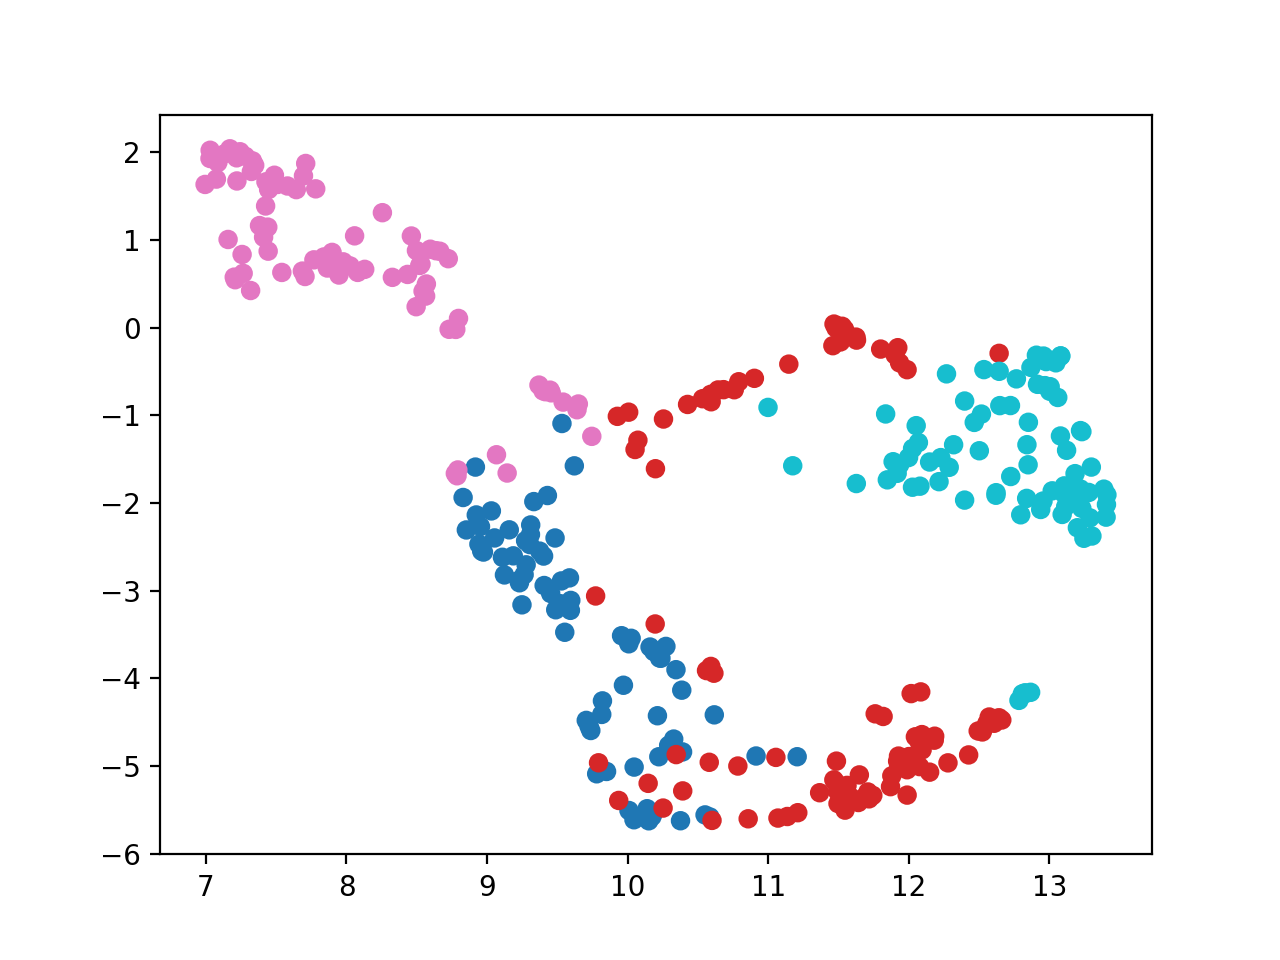

In [54]:
from sklearn.cluster import KMeans
import umap

#kmeans = KMeans(n_clusters=4, random_state=0).fit(imstack)

n_neighbors=30
min_dist=0.1
n_components=2
metric='euclidean'
#metric='canberra'
metric='cosine'
#metric='correlation'


fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=0,
        n_epochs=500,
        spread=0.8,
        local_connectivity=1,
        transform_queue_size=2,
        learning_rate=1,
        unique=True,
        verbose=True
    )
embedding = fit.fit_transform(BigF3);

# fig=plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2],c=cat)
# plt.show()

cmap = plt.cm.tab10
fig=plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embedding[:,0], embedding[:,1],c=ct, cmap=cmap)
plt.show()

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
import cv2
cat=cat.astype(int)
plt.figure(figsize=(10, 10))
cmap = plt.cm.tab10
plt.scatter(embedding[:,0], embedding[:,1], c=cat, s=100, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embedding):
    row=df.iloc[index, :]
    row=row.to_numpy()
    im_square=row.reshape(100,100)
    im_square = cv2.resize(im_square, (20, 20)) 
    im_square=im_square*255
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.05: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(mpl.offsetbox.OffsetImage(im_square, cmap="binary"),position,bboxprops={"edgecolor": 'black', "lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [50]:
from sklearn.cluster import KMeans
import umap

#kmeans = KMeans(n_clusters=4, random_state=0).fit(imstack)

#n_neighbors=10
#min_dist=0.0
#n_components=4

n_neighbors=10
min_dist=0.1
n_components=3

metric='euclidean'
metric='canberra'
#metric='cosine'
#metric='correlation'

fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=0,
        n_epochs=1000,
        verbose=True
    )
embedding_4d = fit.fit_transform(BigF3);

kmeans = KMeans(n_clusters=4, random_state=0).fit(embedding_4d)

print(kmeans.labels_)
print(cat)

#kmeans.labels_[kmeans.labels_==3.0]=5.0
#kmeans.labels_[kmeans.labels_==0.0]=3.0
#kmeans.labels_[kmeans.labels_==5.0]=0.0

list = []
score = np.array(list)
for i, val in enumerate(kmeans.labels_):
    if kmeans.labels_[i] == cat[i]:
        score = np.append(score,1)
    else:
        score = np.append(score,0)

print(score)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='canberra',
     metric_kwds=None, min_dist=0.1, n_components=3, n_epochs=1000,
     n_neighbors=10, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Sun Aug 30 23:00:49 2020 Finding Nearest Neighbors
Sun Aug 30 23:00:49 2020 Finished Nearest Neighbor Search
Sun Aug 30 23:00:49 2020 Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	comple

In [ ]:
kmeans.labels_1=kmeans.labels_
kmeans.labels_1[kmeans.labels_==1.0]=5.0
kmeans.labels_1[kmeans.labels_==3.0]=1.0
kmeans.labels_1[kmeans.labels_==2.0]=6.0
kmeans.labels_1[kmeans.labels_==0.0]=2.0
kmeans.labels_1[kmeans.labels_==5.0]=0.0
kmeans.labels_1[kmeans.labels_==6.0]=3.0

list = []
score = np.array(list)
for i, val in enumerate(kmeans.labels_):
    if kmeans.labels_[i] == cat[i]:
        score = np.append(score,1)
    else:
        score = np.append(score,0)

print(score)

In [ ]:
print(np.sum(score)/len(score))

In [ ]:
fig, axs = plt.subplots(3, 2)
axs[0,0].imshow(im)
plt.draw()
plt.show()